<a href="https://colab.research.google.com/github/Rajaguhan437/Custom_GAN_to_CLIP/blob/main/Basic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
### importing libs

import torch
import pdb
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [3]:
def show(tensor, ch=1, size=(28, 28), num=16):
    data = tensor.detach().cpu().view(-1, ch, *size) # (batch size, channels, height, width)
    grid = make_grid(data[:num], nrow=4).permute(1, 2, 0) # (num, height, width, channels)
    plt.imshow(grid)
    plt.show()

In [4]:
epochs = 500
cur_step = 0
info_step = 469*5

mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64

lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

batch_size = 128
device = "cuda"

dataloader = DataLoader(MNIST("G:\Datasets", download=True, transform=transforms.ToTensor()),batch_size=batch_size, shuffle=True)

# no. of steps = total images / batch size
# here, steps = 60000 / 128 = 468.75

In [5]:
def genBlock( inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)    
    )

class Genrator(nn.Module):
    def __init__(self, z_dim=64, o_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # 64 , 128
            genBlock(h_dim, h_dim*2), # 128, 256
            genBlock(h_dim*2, h_dim*4), # 256, 512
            genBlock(h_dim*4, h_dim*8), # 512, 1024
            genBlock(h_dim*8, h_dim*8), # 1024, 1024
            nn.Linear(h_dim*8, o_dim), # 1024, 784
            nn.Sigmoid()   
        )
        
    def forward(self, noise):
        return self.gen(noise)
    
def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device)

In [20]:
## DiscBlock

def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.LeakyReLU(0.2)    
    )

class Discriminator(nn.Module):
    def __init__(self, o_dim=784, h_dim=128):
      super().__init__()
      self.disc = nn.Sequential(
          discBlock(o_dim, h_dim*8), # 784 , 1024
          discBlock(h_dim*8, h_dim*4), # 1024, 512
          discBlock(h_dim*4, h_dim*2), # 512, 256
          discBlock(h_dim*2, h_dim), # 256, 128
          nn.Linear(h_dim, 1), # 128, 1
        )
        
    def forward(self, image):
        return self.disc(image)

In [21]:
gen = Genrator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [22]:
gen

Genrator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, 

In [23]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [24]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:20])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([1, 1, 5, 9, 5, 0, 8, 6, 8, 1, 2, 4, 0, 8, 5, 3, 1, 8, 0, 0])


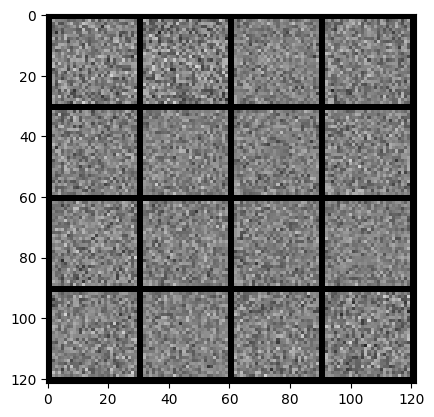

In [25]:
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

In [26]:
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)
    targets = torch.ones_like(pred)
    gen_loss = loss_func(pred, targets)
    
    return gen_loss

In [29]:
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
    
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    
    pred_fake = disc(fake.detach())
    pred_fake_targets = torch.zeros_like(pred_fake)
    pred_fake_loss = loss_func(pred_fake, pred_fake_targets)
    
    pred_real = disc(real)
    pred_real_targets = torch.ones_like(pred_real)
    pred_real_loss = loss_func(pred_real, pred_real_targets)
    
    disc_loss = (pred_real_loss + pred_fake_loss) / 2
    
    return disc_loss



  0%|          | 0/469 [00:00<?, ?it/s]

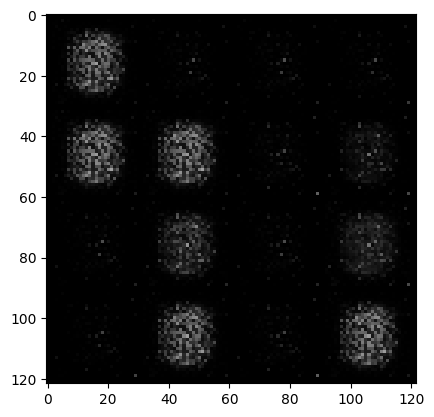

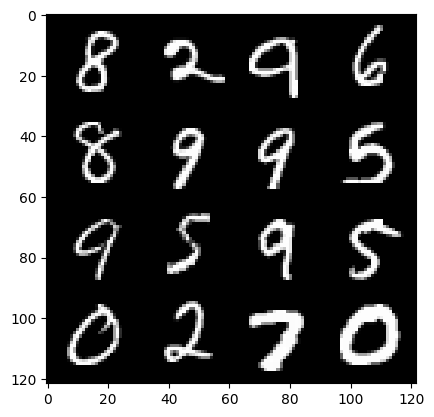

Epoch = 0 cur_step = 14070 disc_loss = 0.5977991921457845 gen_loss = 1.0704211580219554


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

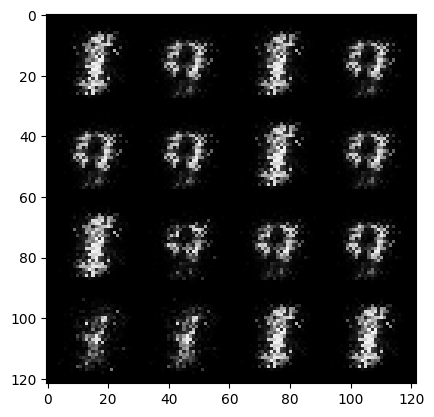

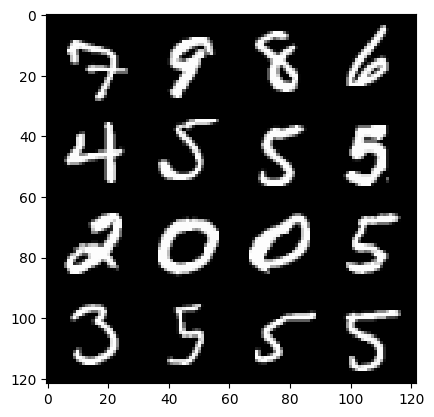

Epoch = 5 cur_step = 16415 disc_loss = 0.13376935471468834 gen_loss = 3.237934264292849


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

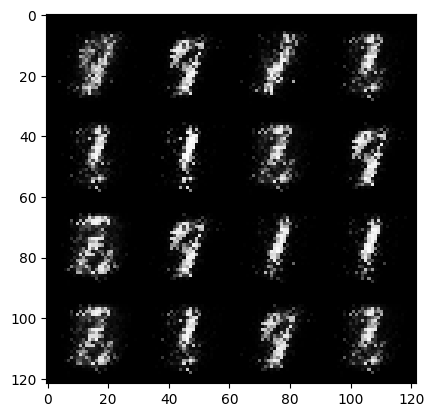

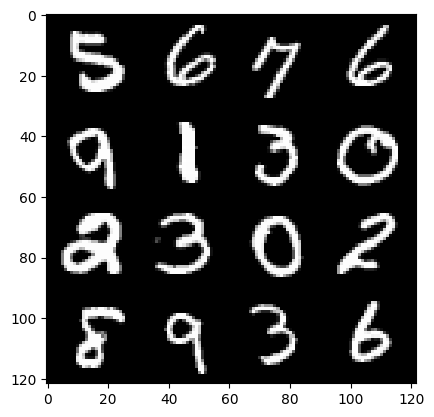

Epoch = 10 cur_step = 18760 disc_loss = 0.06346445737569444 gen_loss = 3.7619710908007264


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

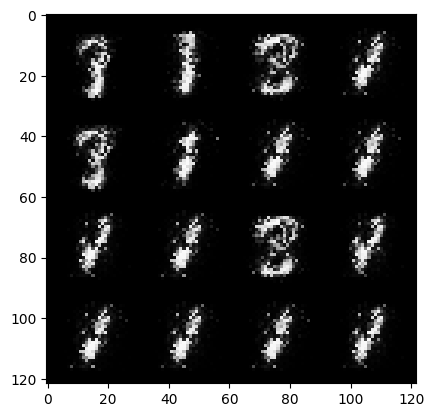

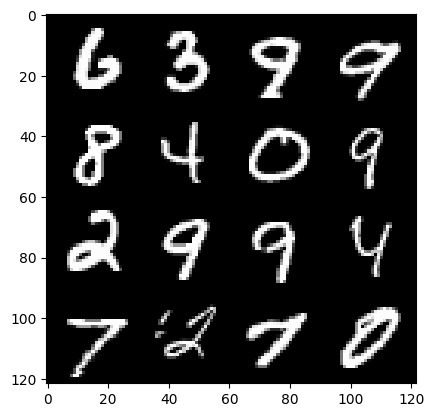

Epoch = 15 cur_step = 21105 disc_loss = 0.08980267911609302 gen_loss = 3.8209779337779293


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

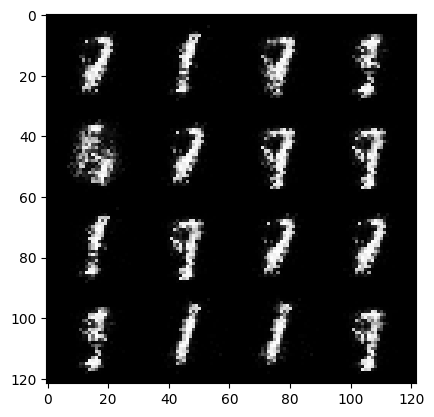

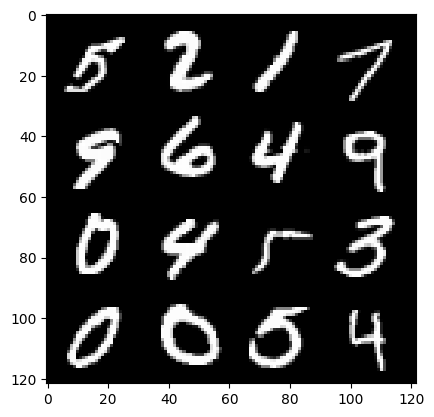

Epoch = 20 cur_step = 23450 disc_loss = 0.10556122471433459 gen_loss = 3.6687389792663962


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

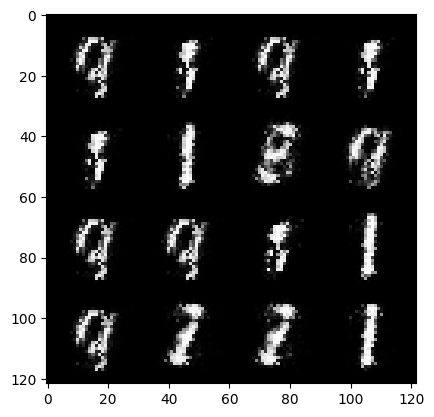

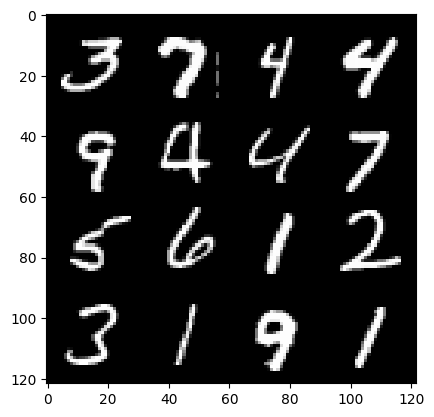

Epoch = 25 cur_step = 25795 disc_loss = 0.1336247416336272 gen_loss = 3.3125113887827533


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

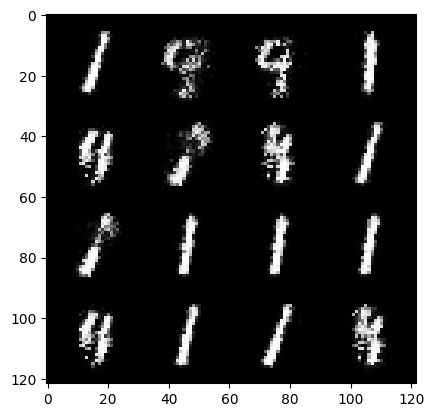

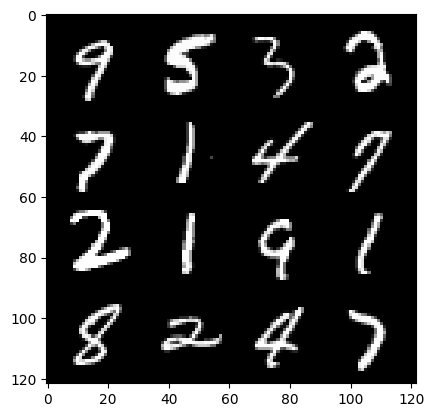

Epoch = 30 cur_step = 28140 disc_loss = 0.130350916182944 gen_loss = 3.313760538751891


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

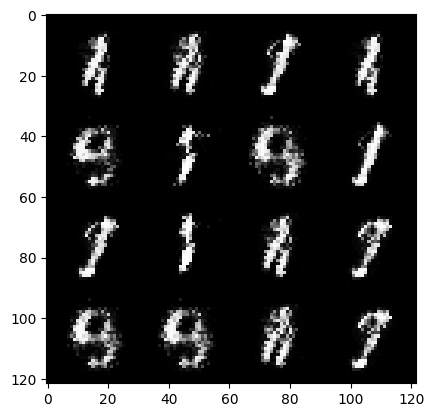

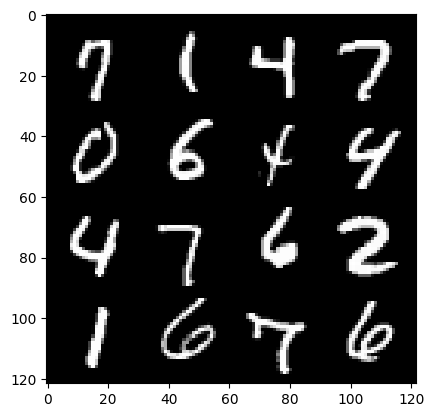

Epoch = 35 cur_step = 30485 disc_loss = 0.17310814134347668 gen_loss = 2.99742148669798


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

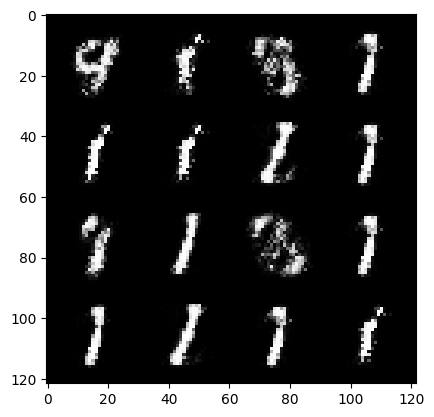

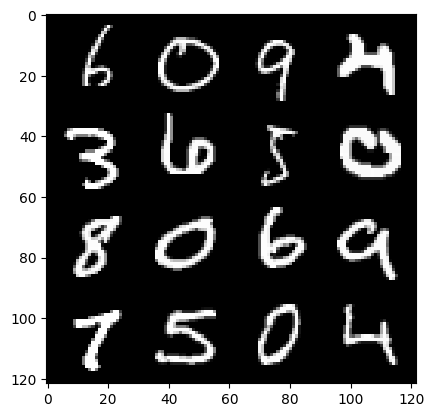

Epoch = 40 cur_step = 32830 disc_loss = 0.22861891502002155 gen_loss = 2.6776191288982627


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

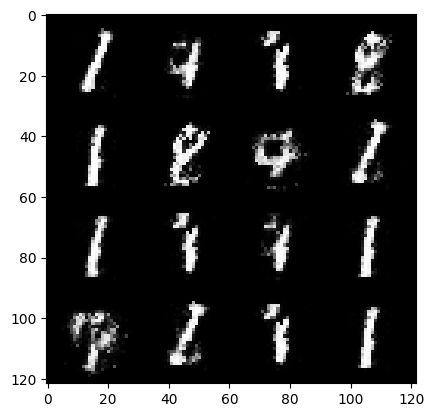

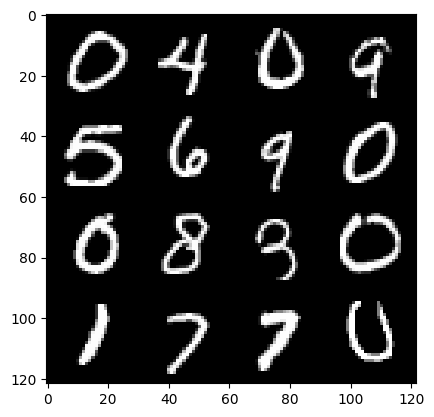

Epoch = 45 cur_step = 35175 disc_loss = 0.24571734433616402 gen_loss = 2.4237275122071127


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

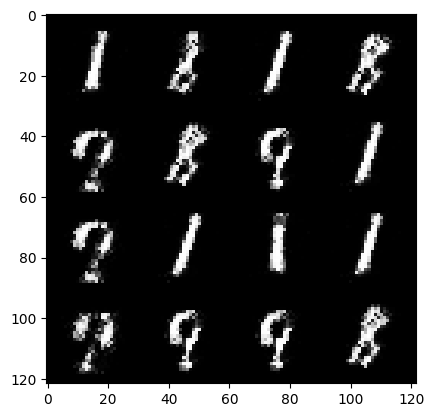

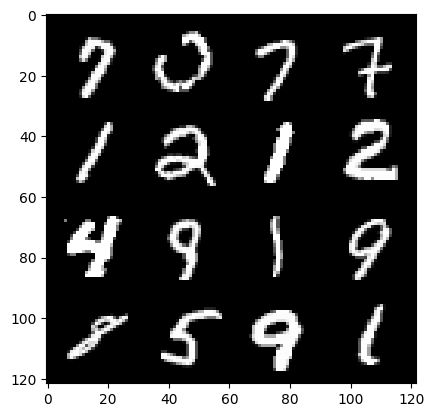

Epoch = 50 cur_step = 37520 disc_loss = 0.2396457441262345 gen_loss = 2.3911984565161437


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

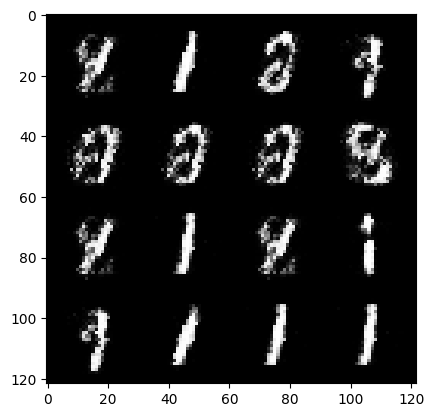

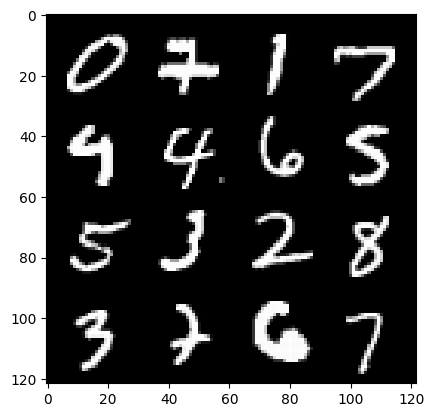

Epoch = 55 cur_step = 39865 disc_loss = 0.2490218340651567 gen_loss = 2.3058287652062455


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

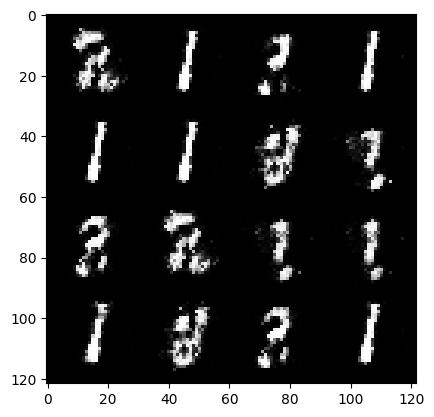

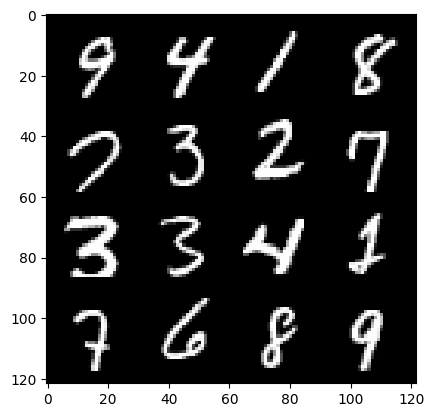

Epoch = 60 cur_step = 42210 disc_loss = 0.25504650410050267 gen_loss = 2.233910251222948


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

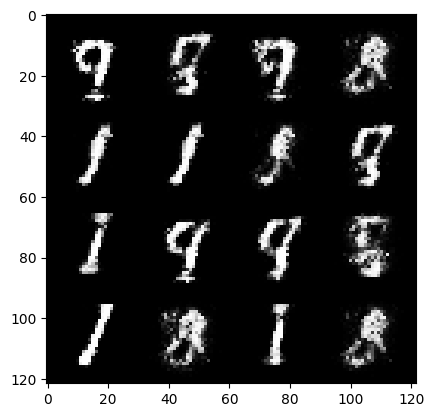

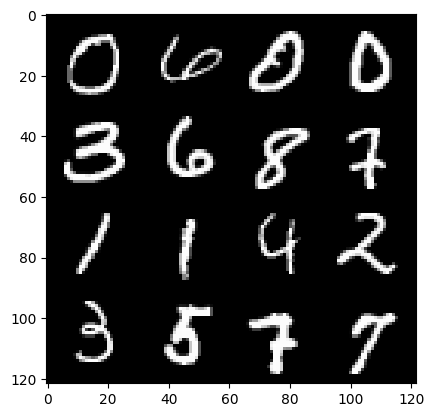

Epoch = 65 cur_step = 44555 disc_loss = 0.26795568236473527 gen_loss = 2.18563010209659


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

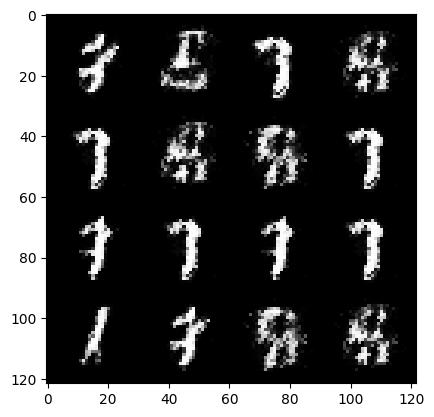

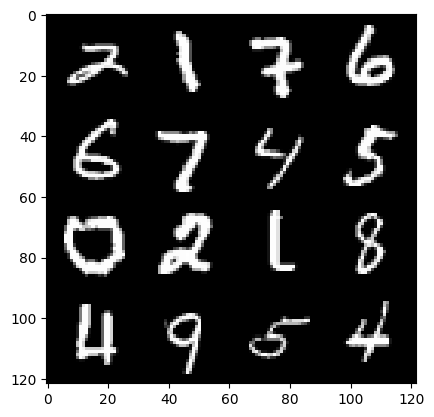

Epoch = 70 cur_step = 46900 disc_loss = 0.2501319794893773 gen_loss = 2.238502316027562


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

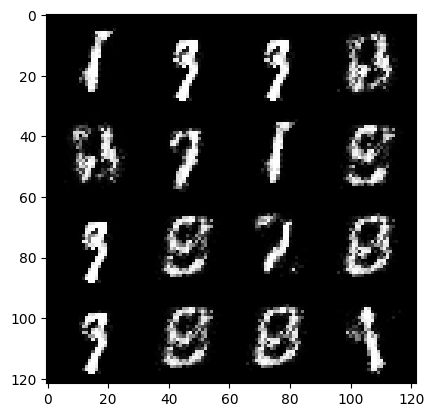

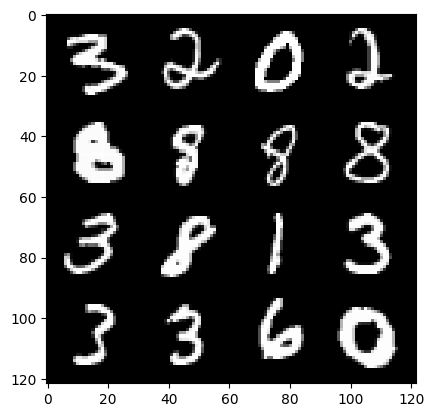

Epoch = 75 cur_step = 49245 disc_loss = 0.2657662028951177 gen_loss = 2.1549870277518655


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

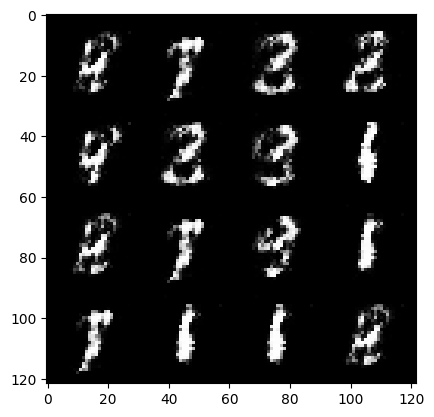

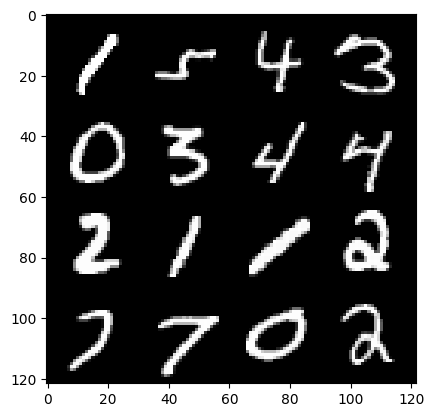

Epoch = 80 cur_step = 51590 disc_loss = 0.2770579410832065 gen_loss = 2.0806473213472345


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

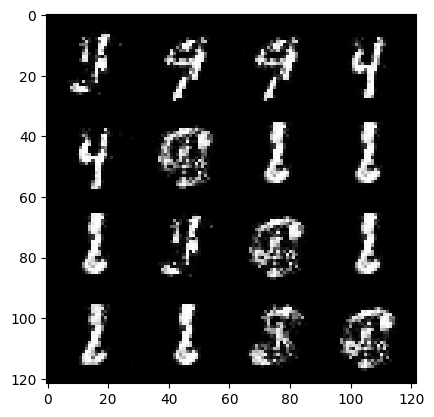

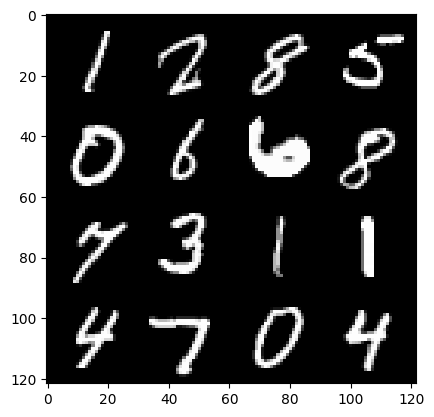

Epoch = 85 cur_step = 53935 disc_loss = 0.2909419744253667 gen_loss = 1.9719421427387165


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

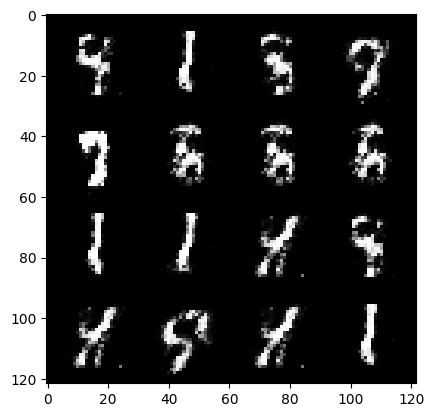

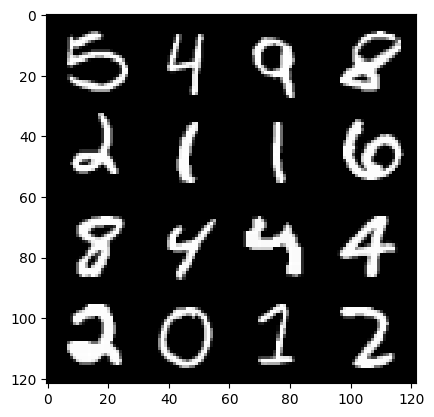

Epoch = 90 cur_step = 56280 disc_loss = 0.32891738053832226 gen_loss = 1.7925634591055832


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

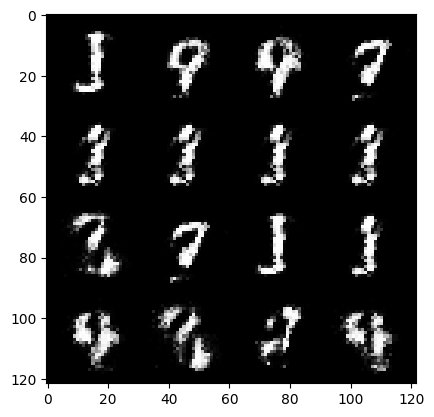

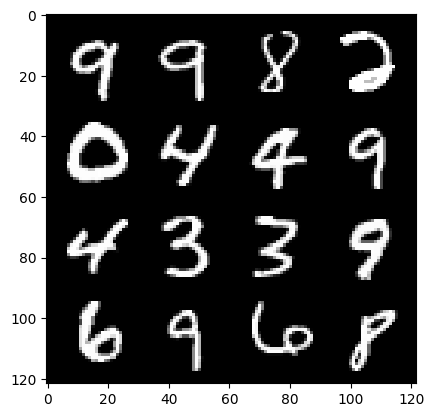

Epoch = 95 cur_step = 58625 disc_loss = 0.31162838235592794 gen_loss = 1.8282021640460375


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

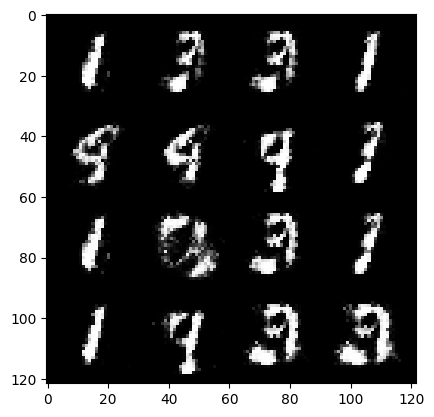

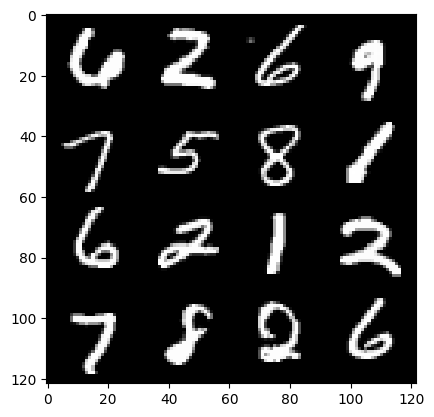

Epoch = 100 cur_step = 60970 disc_loss = 0.2815567398503391 gen_loss = 1.947836656712774


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

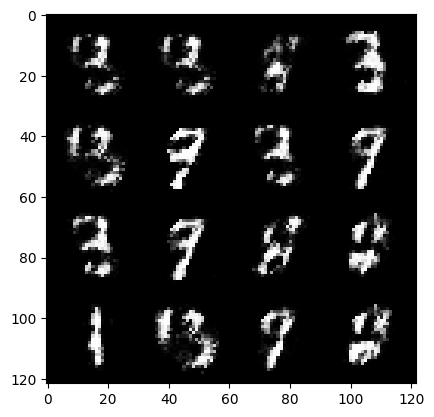

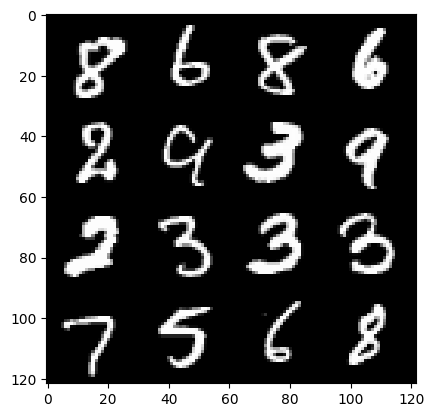

Epoch = 105 cur_step = 63315 disc_loss = 0.3004074209979348 gen_loss = 1.8475327887768938


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

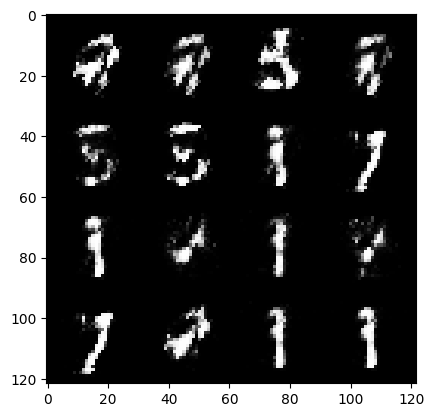

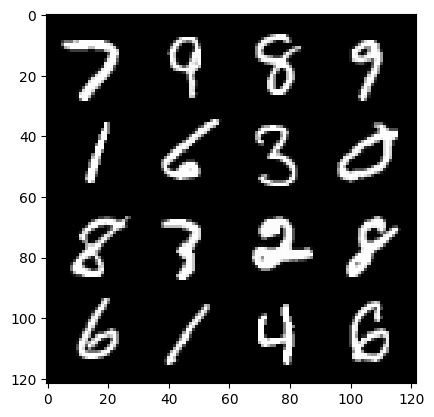

Epoch = 110 cur_step = 65660 disc_loss = 0.3296594735274691 gen_loss = 1.6592955778910916


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

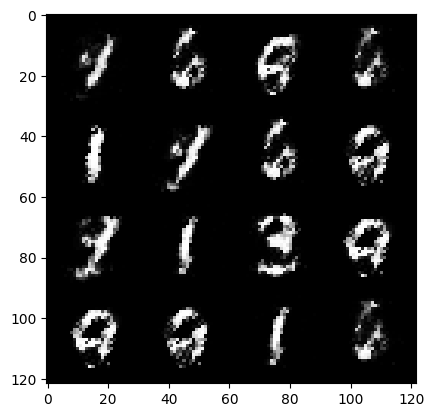

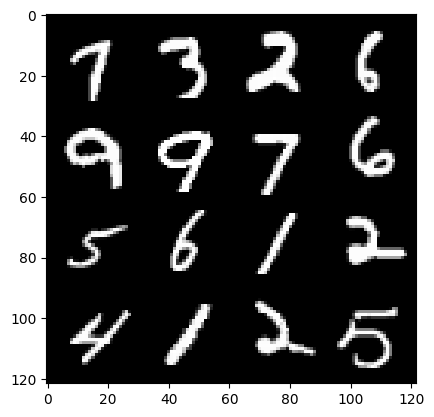

Epoch = 115 cur_step = 68005 disc_loss = 0.33182951267848393 gen_loss = 1.671551749040323


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

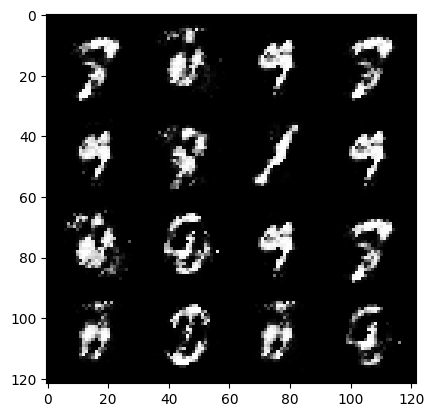

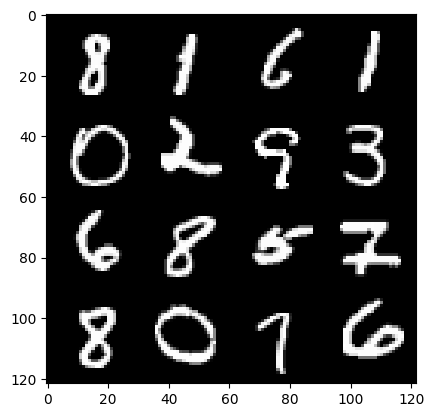

Epoch = 120 cur_step = 70350 disc_loss = 0.33276344361717003 gen_loss = 1.635420309760169


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

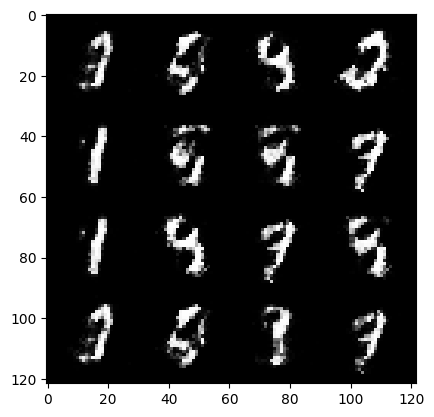

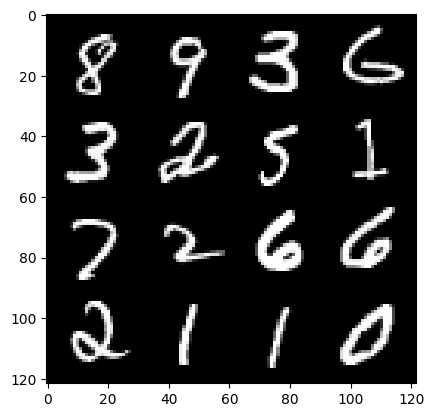

Epoch = 125 cur_step = 72695 disc_loss = 0.3598212346911176 gen_loss = 1.5404606055603354


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

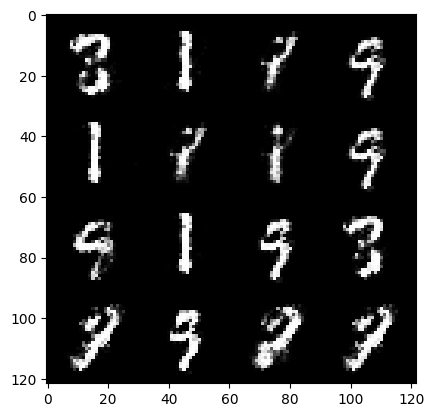

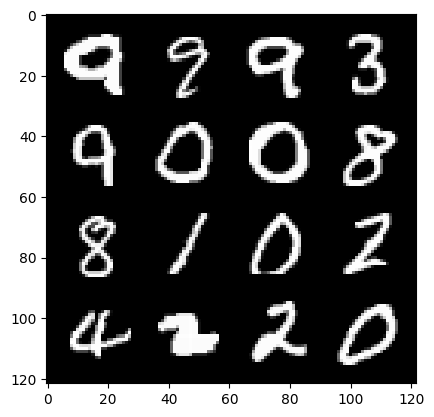

Epoch = 130 cur_step = 75040 disc_loss = 0.3393825231584659 gen_loss = 1.635631587002069


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

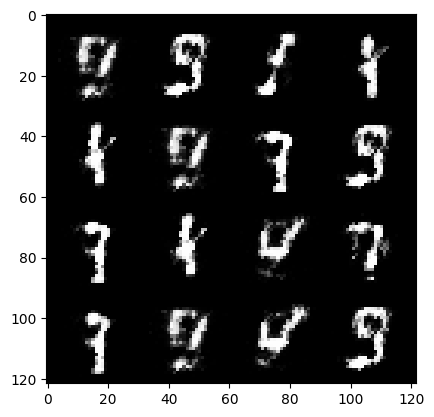

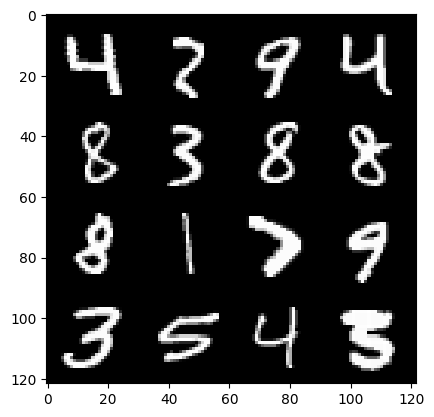

Epoch = 135 cur_step = 77385 disc_loss = 0.382432206181575 gen_loss = 1.4574633193931092


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

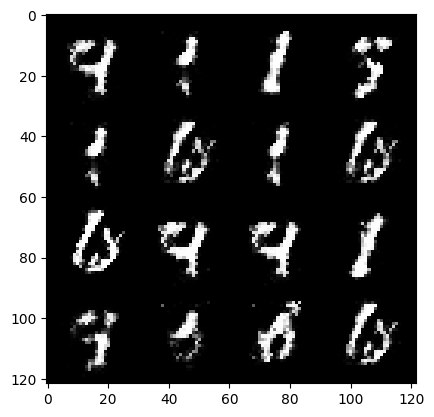

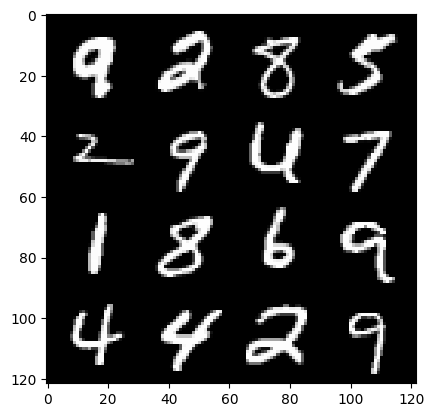

Epoch = 140 cur_step = 79730 disc_loss = 0.37035506145913466 gen_loss = 1.485541059772597


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

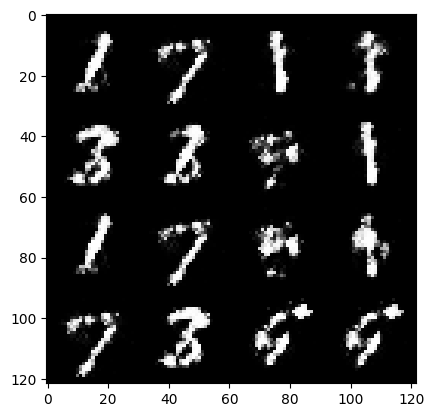

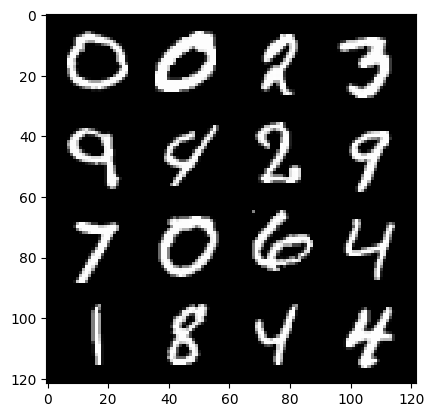

Epoch = 145 cur_step = 82075 disc_loss = 0.36751732532657794 gen_loss = 1.5191983365300876


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

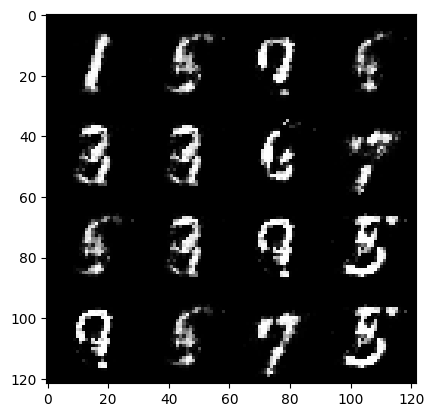

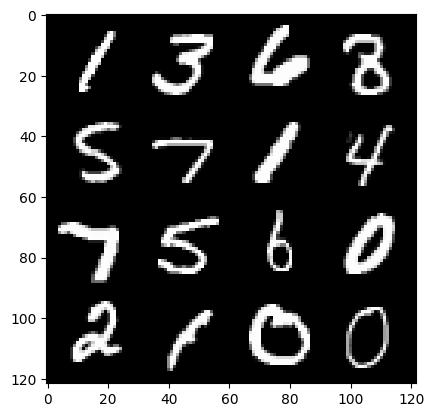

Epoch = 150 cur_step = 84420 disc_loss = 0.402274701202602 gen_loss = 1.3780417265414175


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

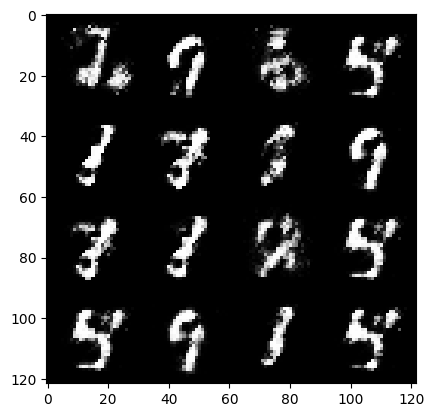

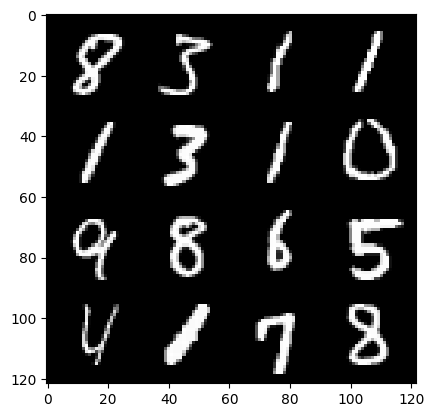

Epoch = 155 cur_step = 86765 disc_loss = 0.4281135778945646 gen_loss = 1.3080259623303852


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

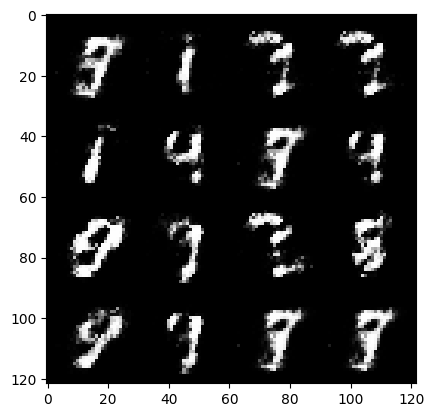

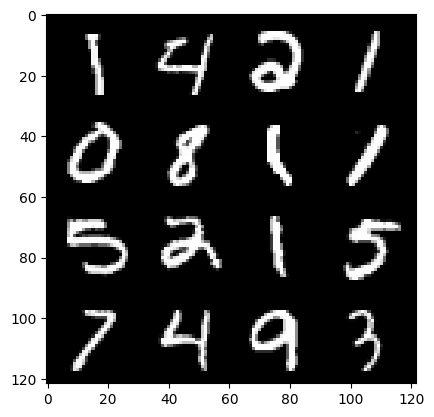

Epoch = 160 cur_step = 89110 disc_loss = 0.40205641543941456 gen_loss = 1.3940339156559536


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

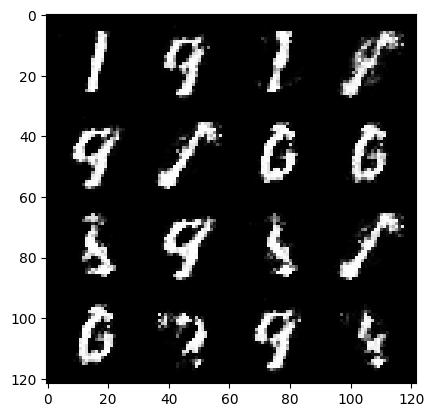

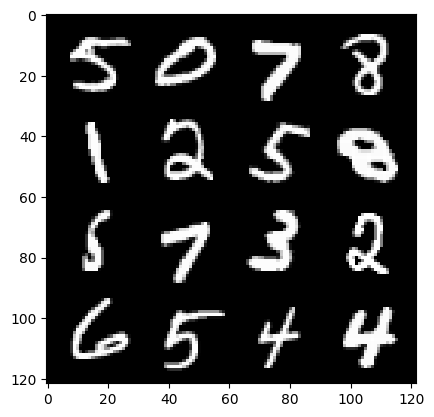

Epoch = 165 cur_step = 91455 disc_loss = 0.4372563801975901 gen_loss = 1.2600823073244807


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

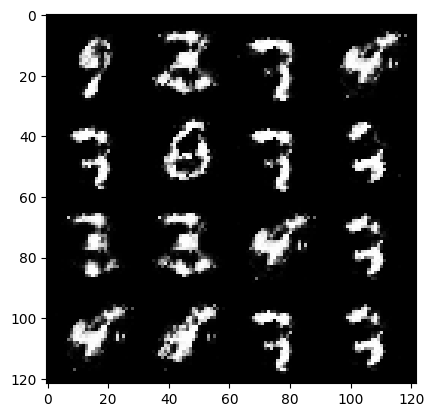

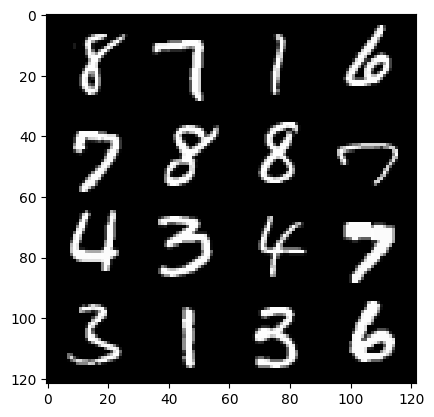

Epoch = 170 cur_step = 93800 disc_loss = 0.45867154878466876 gen_loss = 1.2372714712167345


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

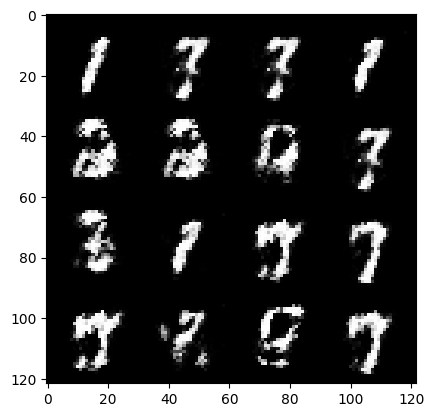

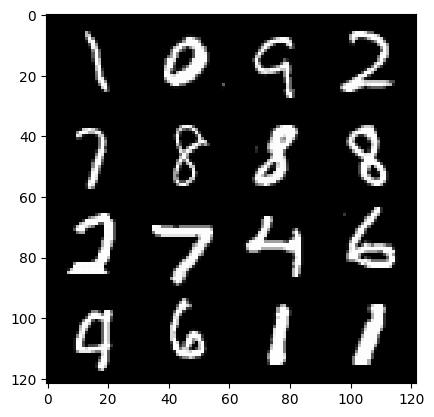

Epoch = 175 cur_step = 96145 disc_loss = 0.4232424488453977 gen_loss = 1.3429445985537856


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

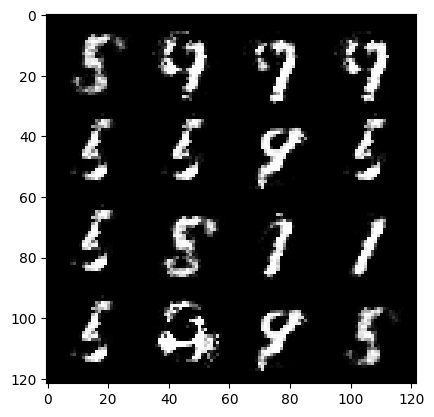

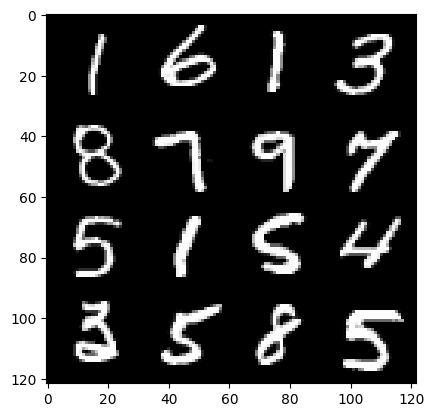

Epoch = 180 cur_step = 98490 disc_loss = 0.43594320618521687 gen_loss = 1.2852339154367507


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

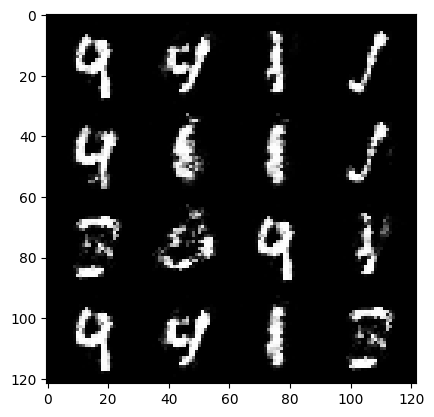

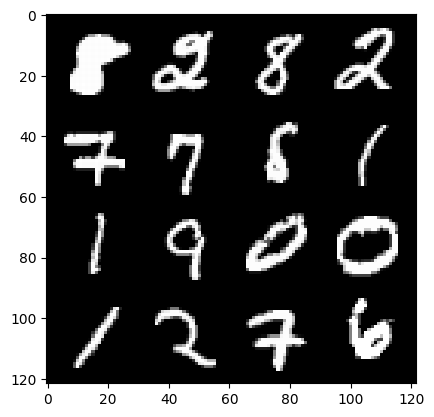

Epoch = 185 cur_step = 100835 disc_loss = 0.4166803116864487 gen_loss = 1.3775308413292044


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

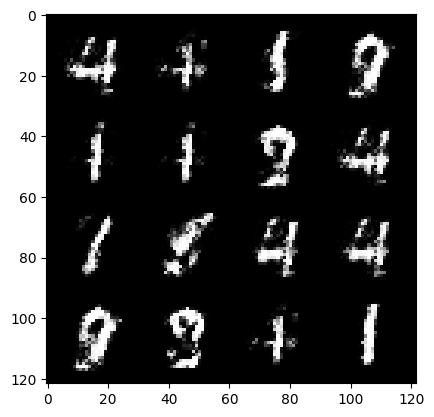

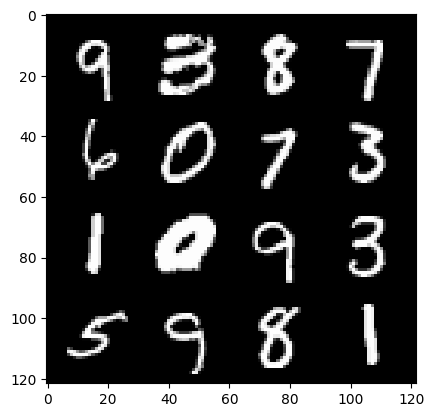

Epoch = 190 cur_step = 103180 disc_loss = 0.4085958859686658 gen_loss = 1.3975045654565286


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

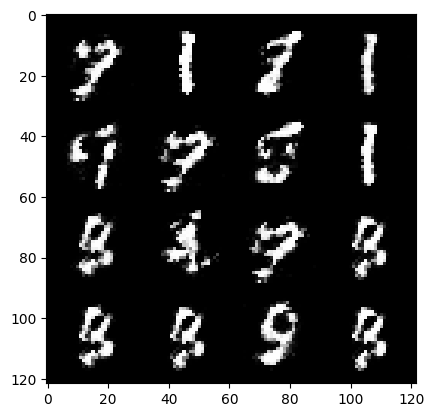

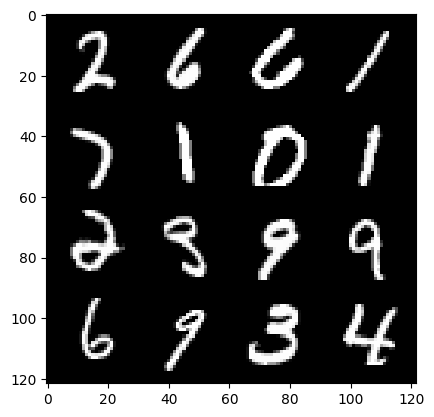

Epoch = 195 cur_step = 105525 disc_loss = 0.43848991198326226 gen_loss = 1.305829891263803


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

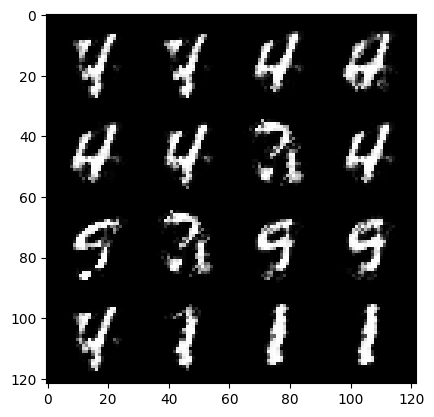

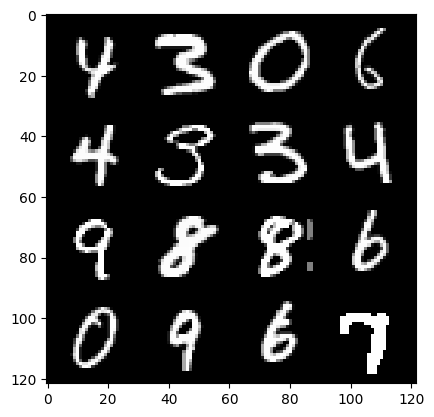

Epoch = 200 cur_step = 107870 disc_loss = 0.4477829235067754 gen_loss = 1.2986210570660734


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

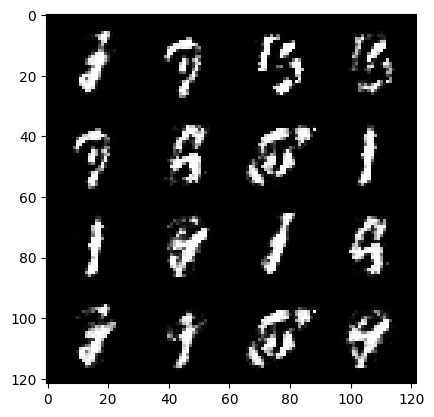

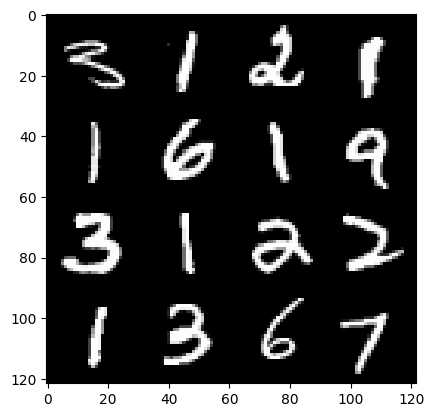

Epoch = 205 cur_step = 110215 disc_loss = 0.42490892438237854 gen_loss = 1.3298940215537798


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

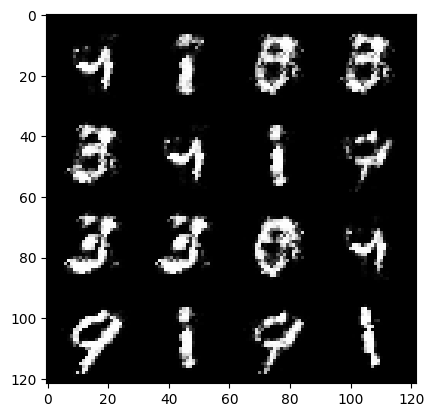

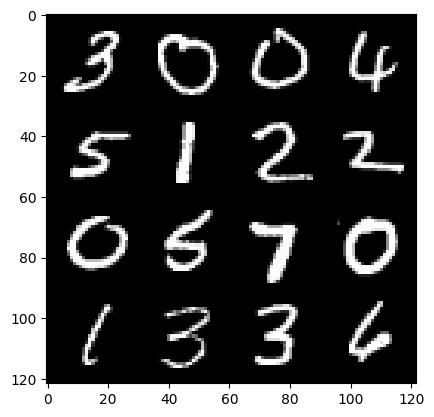

Epoch = 210 cur_step = 112560 disc_loss = 0.42938713046279287 gen_loss = 1.354999967755031


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

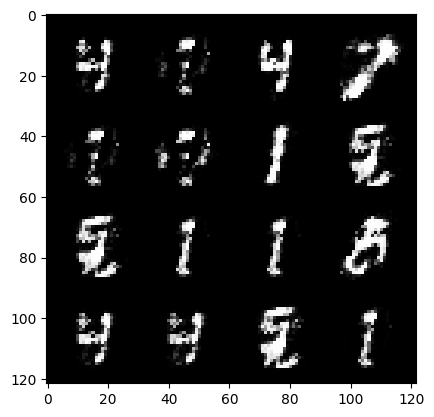

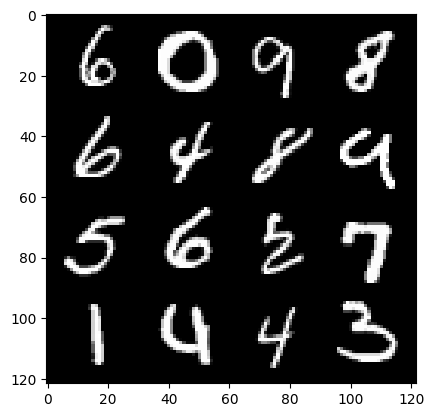

Epoch = 215 cur_step = 114905 disc_loss = 0.3910167188341938 gen_loss = 1.4708481587834958


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

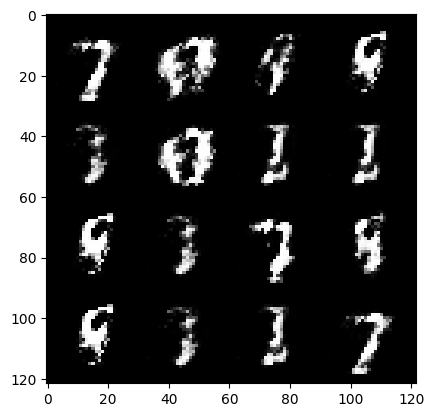

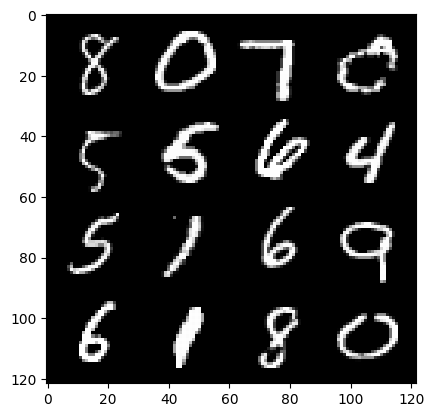

Epoch = 220 cur_step = 117250 disc_loss = 0.42006386668443174 gen_loss = 1.3725010410046528


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

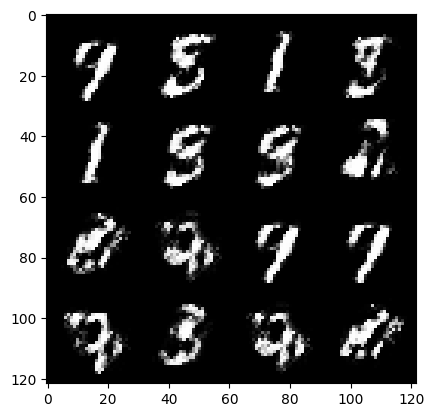

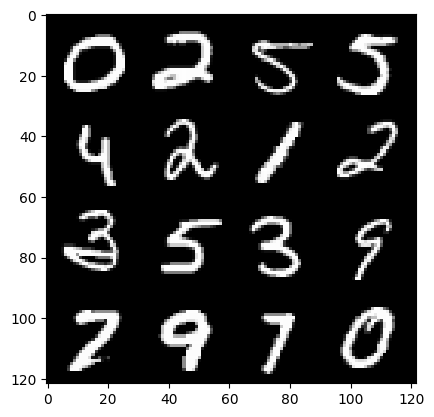

Epoch = 225 cur_step = 119595 disc_loss = 0.3840676816096946 gen_loss = 1.5029847426709335


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

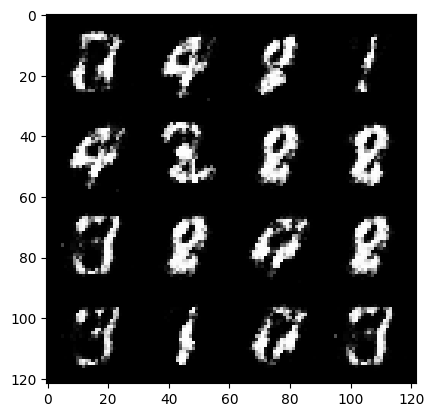

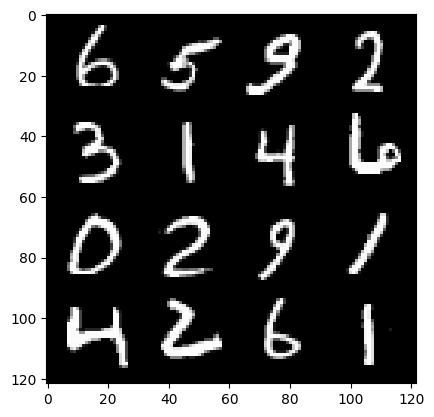

Epoch = 230 cur_step = 121940 disc_loss = 0.3722597671914965 gen_loss = 1.5457926654103977


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

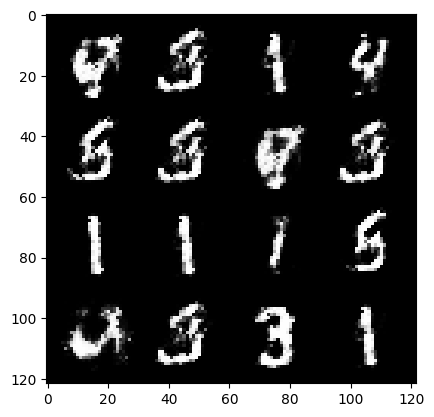

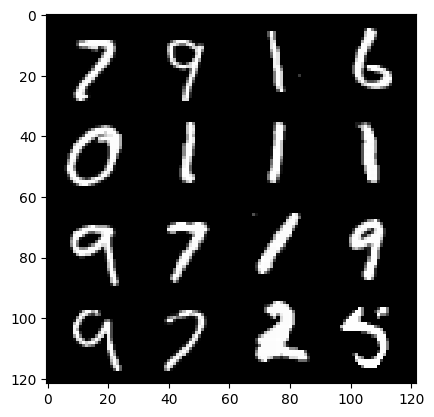

Epoch = 235 cur_step = 124285 disc_loss = 0.4315443151414013 gen_loss = 1.3570292220695186


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

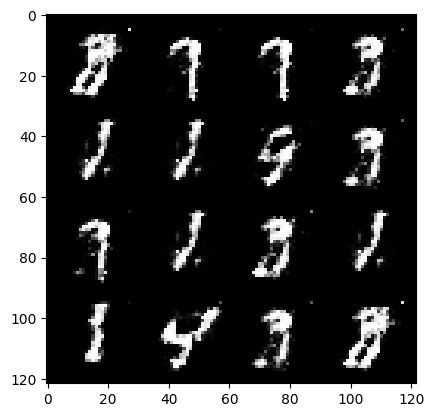

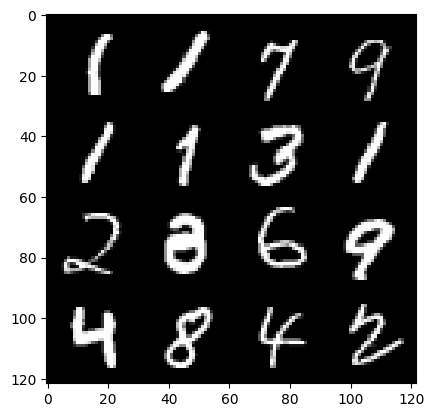

Epoch = 240 cur_step = 126630 disc_loss = 0.4324318452557521 gen_loss = 1.367014885838352


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

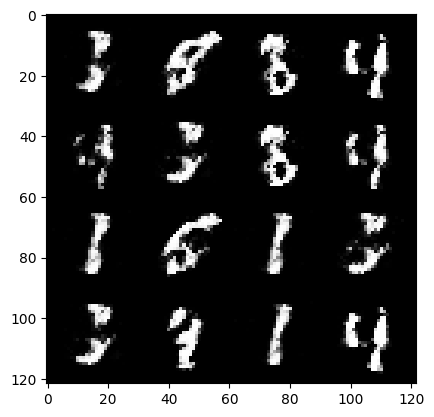

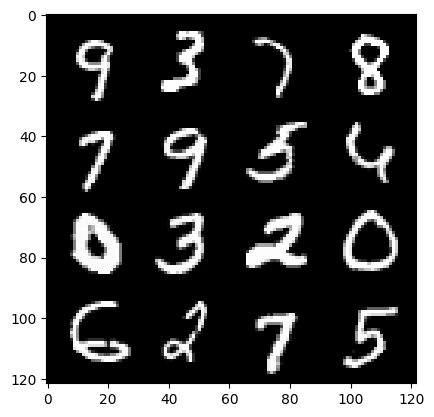

Epoch = 245 cur_step = 128975 disc_loss = 0.3921174018939675 gen_loss = 1.4664953277309312


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

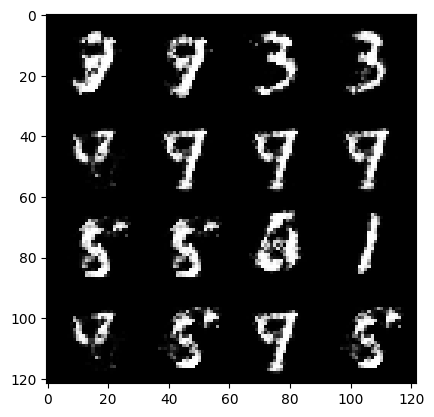

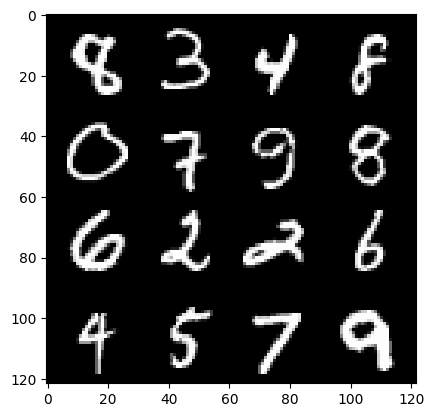

Epoch = 250 cur_step = 131320 disc_loss = 0.36277047749013025 gen_loss = 1.607386246012218


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

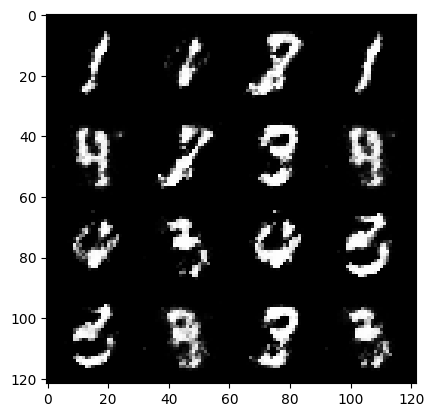

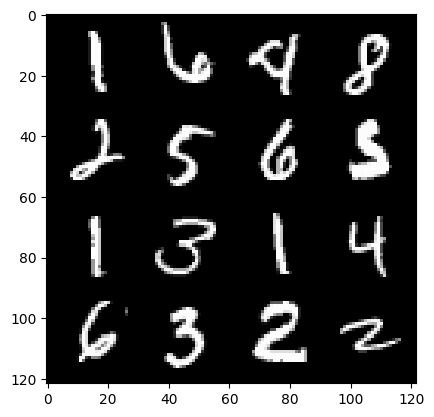

Epoch = 255 cur_step = 133665 disc_loss = 0.40353758761496433 gen_loss = 1.4547091427896577


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

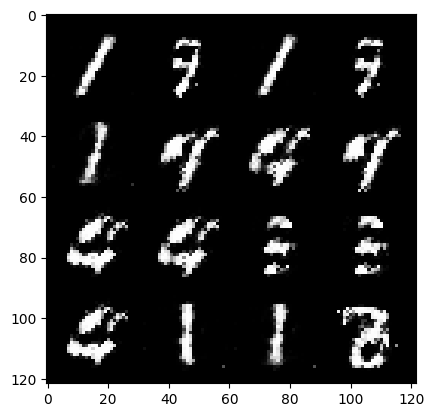

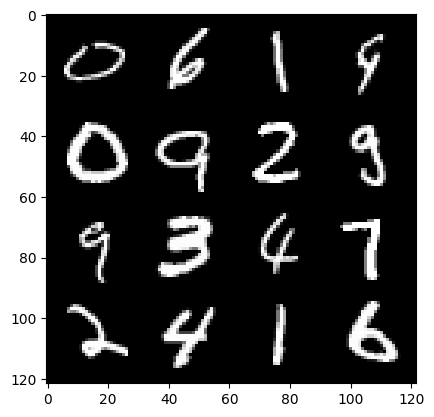

Epoch = 260 cur_step = 136010 disc_loss = 0.42024886533776834 gen_loss = 1.4099714634769254


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

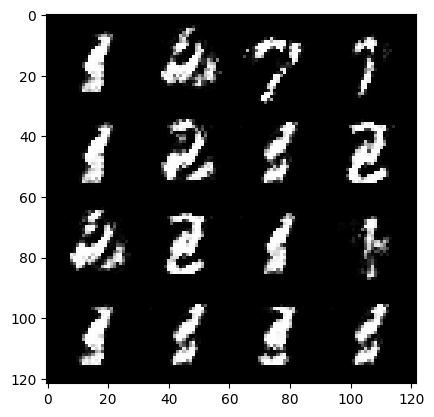

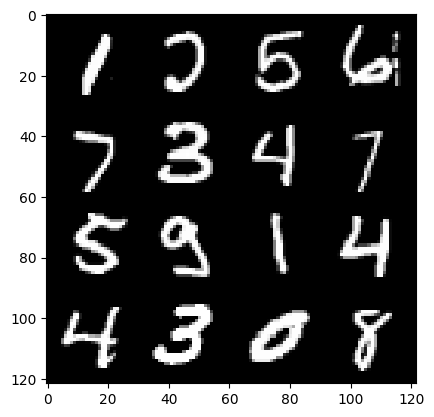

Epoch = 265 cur_step = 138355 disc_loss = 0.3842317211411909 gen_loss = 1.5298730191391414


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

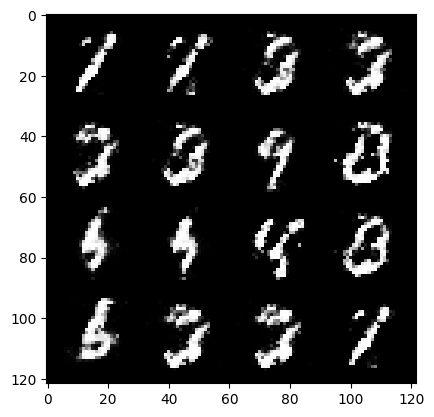

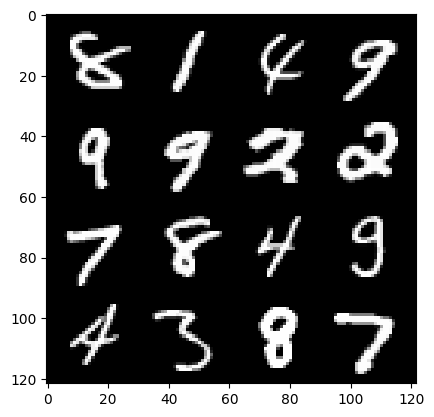

Epoch = 270 cur_step = 140700 disc_loss = 0.37190269166345535 gen_loss = 1.5628570815393412


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

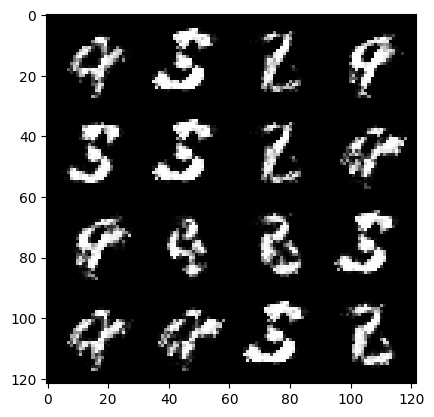

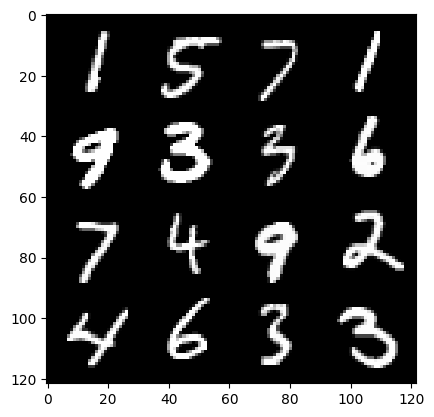

Epoch = 275 cur_step = 143045 disc_loss = 0.3902666091219957 gen_loss = 1.5313023654128444


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

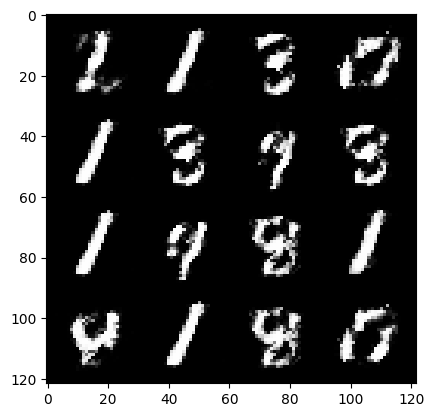

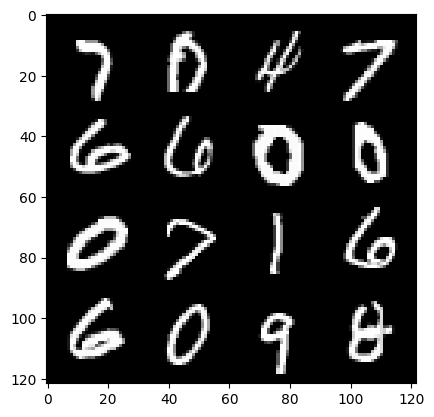

Epoch = 280 cur_step = 145390 disc_loss = 0.39187368597430206 gen_loss = 1.490817796497711


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

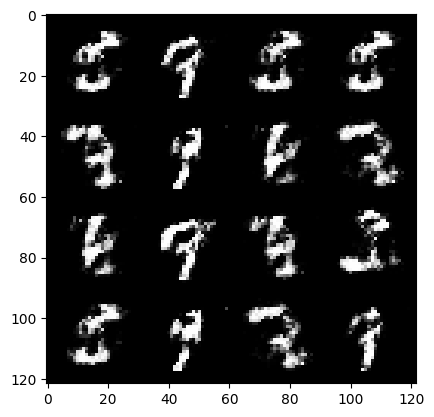

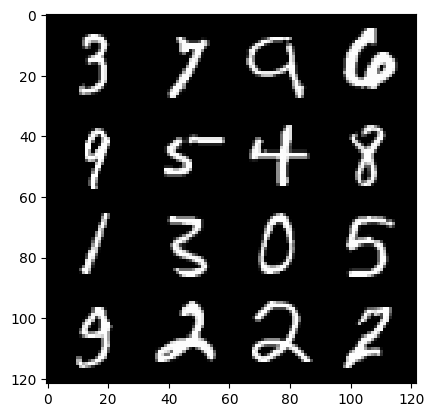

Epoch = 285 cur_step = 147735 disc_loss = 0.4318209611784929 gen_loss = 1.3801744520282948


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

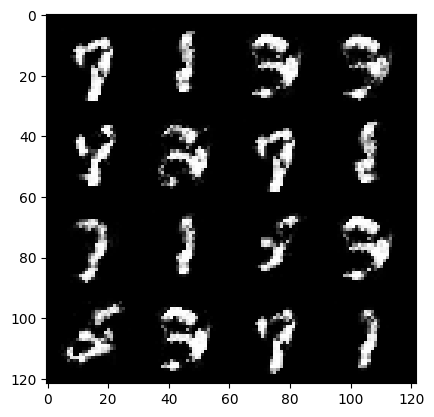

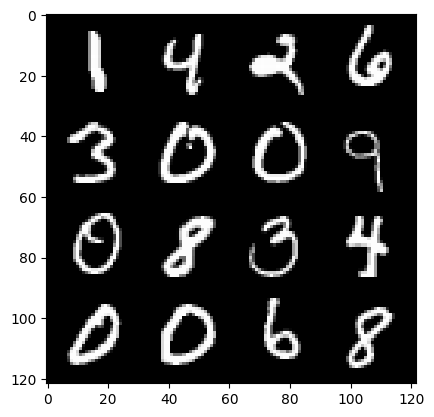

Epoch = 290 cur_step = 150080 disc_loss = 0.4047130013897475 gen_loss = 1.4582550384596722


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

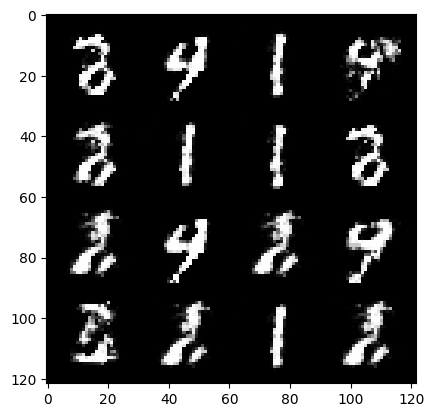

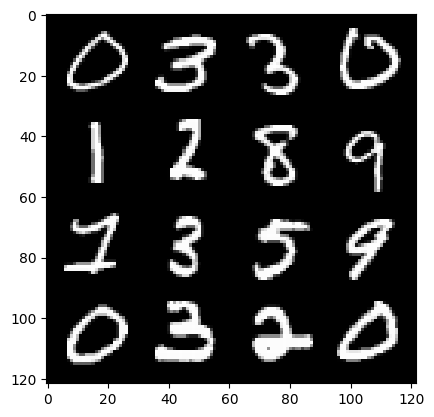

Epoch = 295 cur_step = 152425 disc_loss = 0.34879022250170394 gen_loss = 1.7547473707687118


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

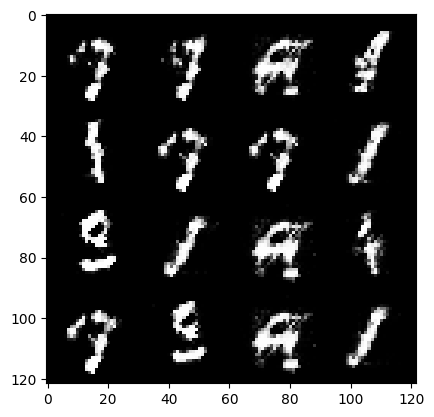

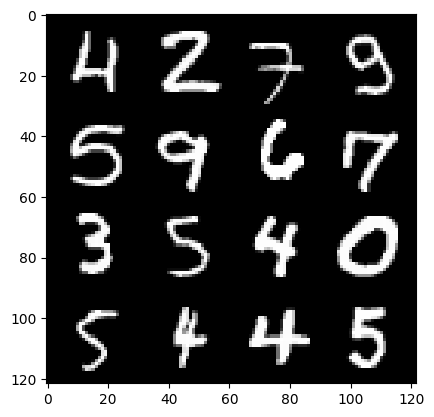

Epoch = 300 cur_step = 154770 disc_loss = 0.3534159205742736 gen_loss = 1.6921977569807822


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

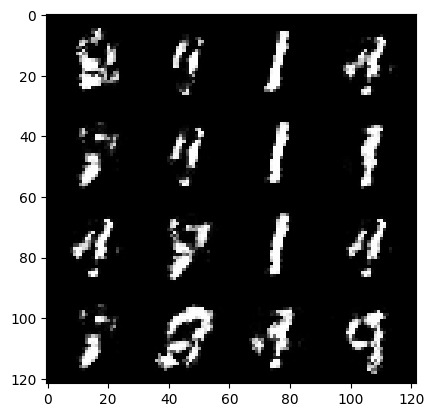

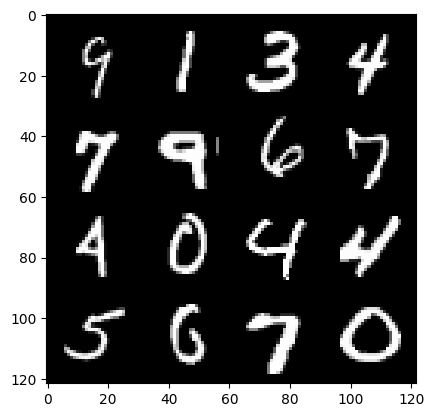

Epoch = 305 cur_step = 157115 disc_loss = 0.33826758125062184 gen_loss = 1.6904616145945306


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

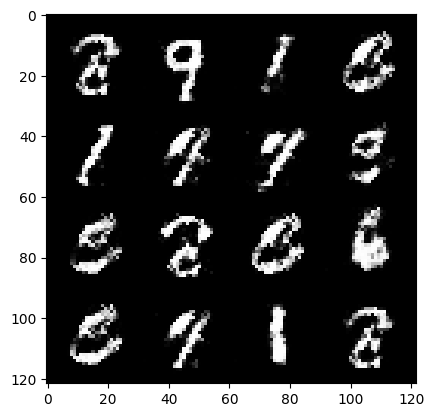

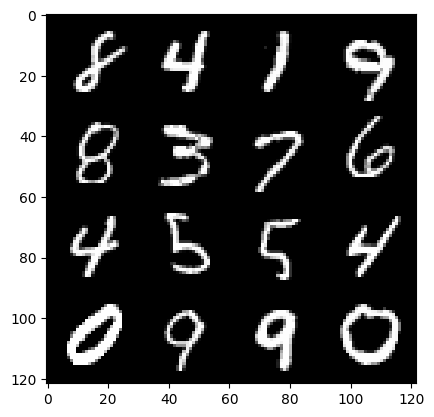

Epoch = 310 cur_step = 159460 disc_loss = 0.3619756376692481 gen_loss = 1.6401230139010496


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

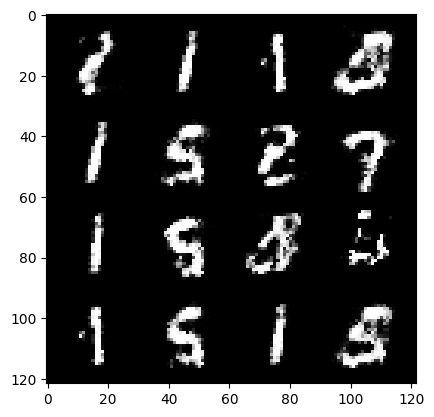

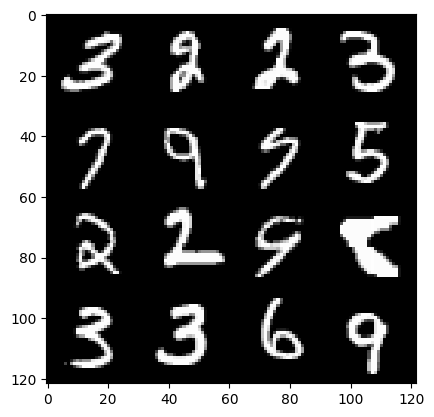

Epoch = 315 cur_step = 161805 disc_loss = 0.37615701670585666 gen_loss = 1.5658517122268676


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

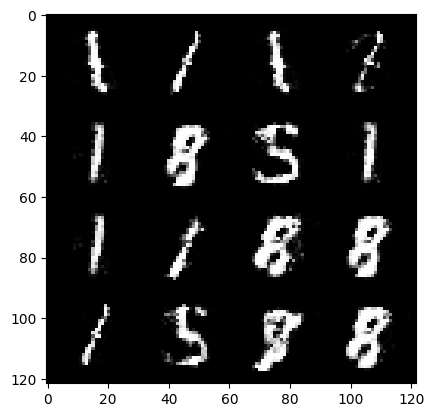

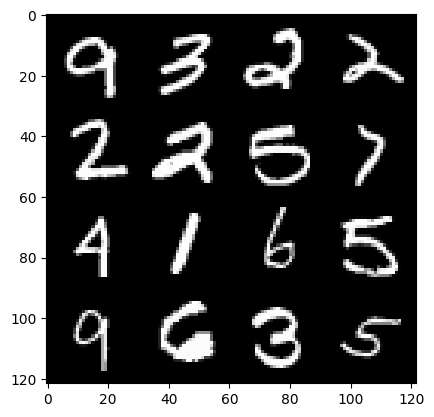

Epoch = 320 cur_step = 164150 disc_loss = 0.3945261532246177 gen_loss = 1.4936035824228706


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

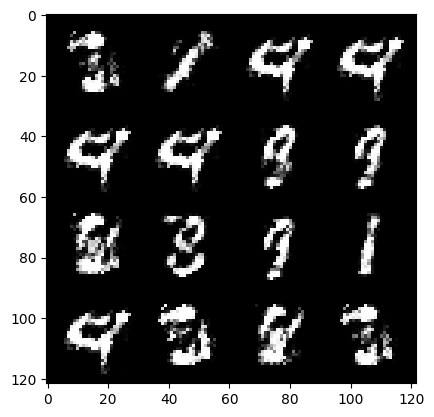

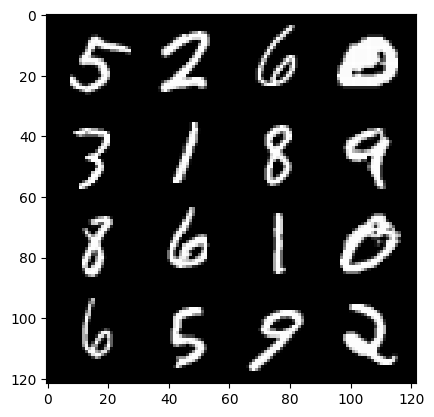

Epoch = 325 cur_step = 166495 disc_loss = 0.3805324604325711 gen_loss = 1.53377834784705


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

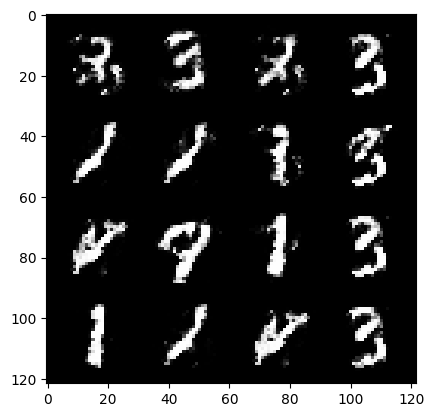

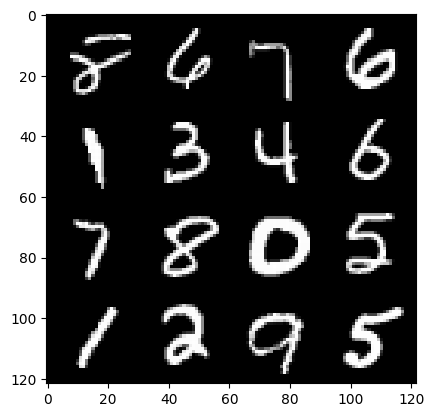

Epoch = 330 cur_step = 168840 disc_loss = 0.3610012657416146 gen_loss = 1.6386609393650535


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

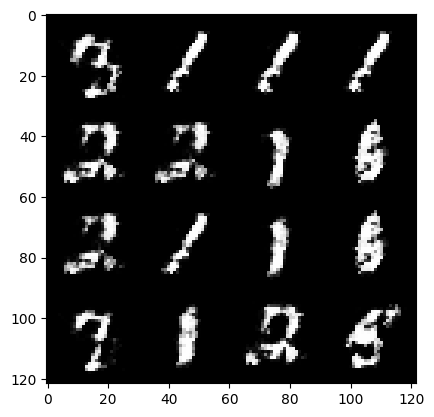

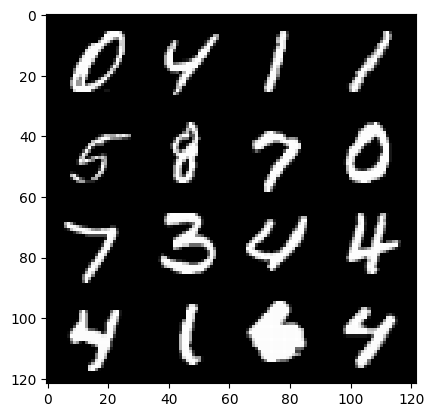

Epoch = 335 cur_step = 171185 disc_loss = 0.39279385061660554 gen_loss = 1.4964459332321753


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

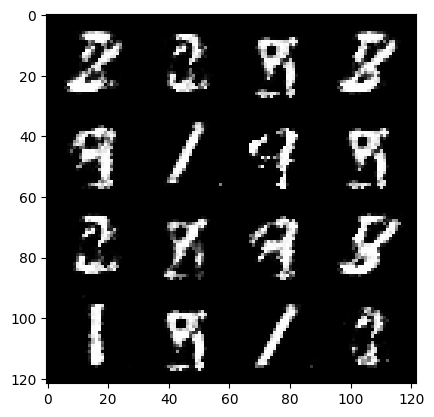

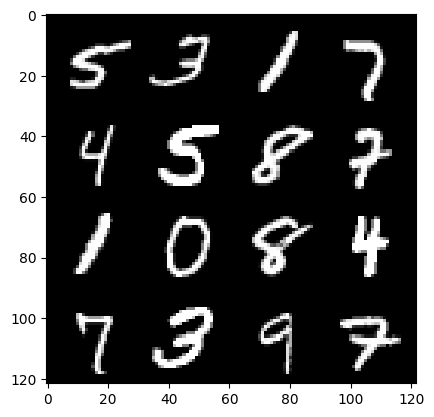

Epoch = 340 cur_step = 173530 disc_loss = 0.3666706659646431 gen_loss = 1.5757837582752903


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

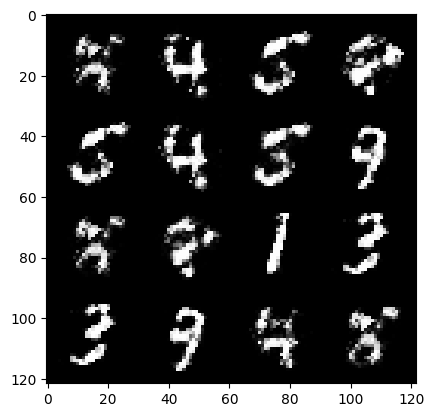

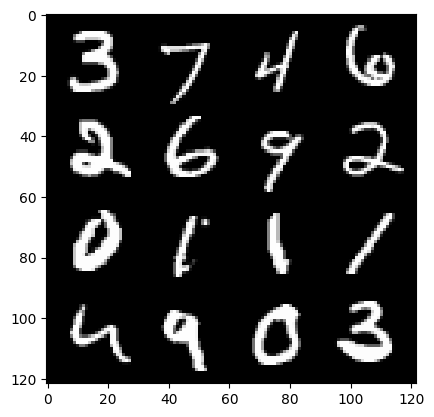

Epoch = 345 cur_step = 175875 disc_loss = 0.3969872804148111 gen_loss = 1.4859447959643692


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

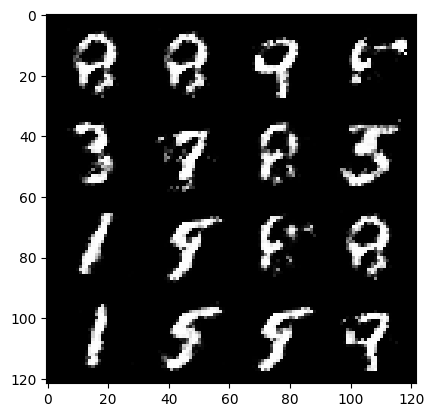

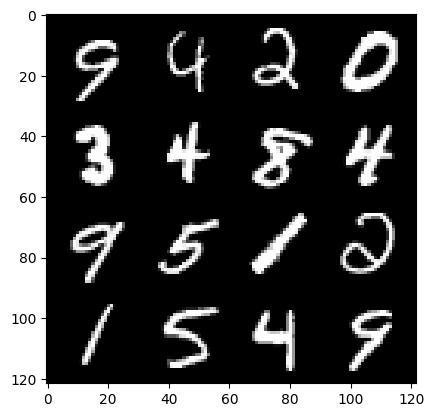

Epoch = 350 cur_step = 178220 disc_loss = 0.38442749166285306 gen_loss = 1.5316188014138228


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

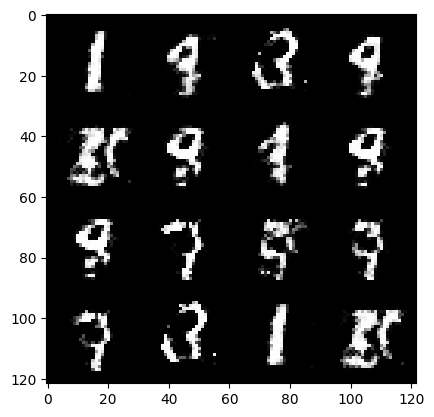

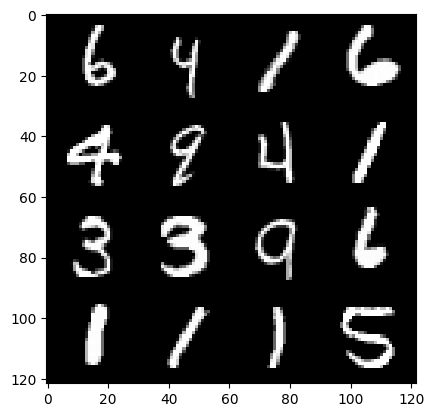

Epoch = 355 cur_step = 180565 disc_loss = 0.3893564541456796 gen_loss = 1.5149145672316235


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

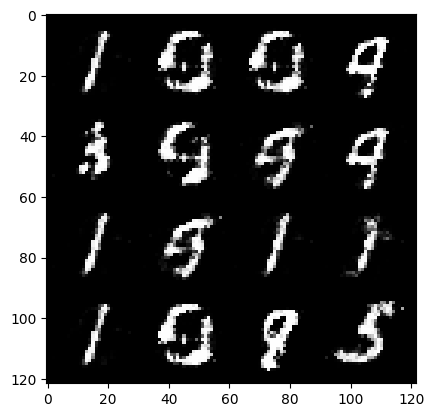

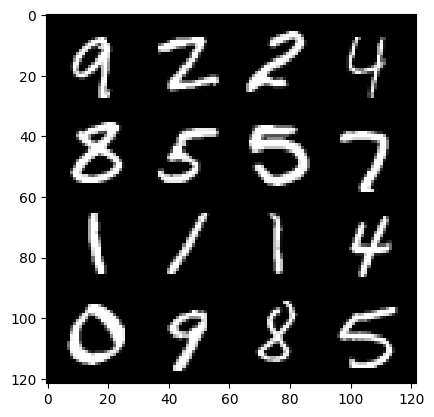

Epoch = 360 cur_step = 182910 disc_loss = 0.38807490231004604 gen_loss = 1.5348883814140677


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

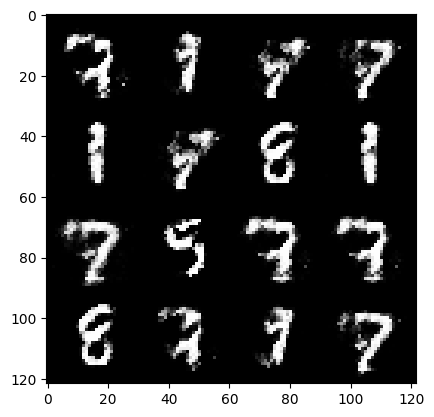

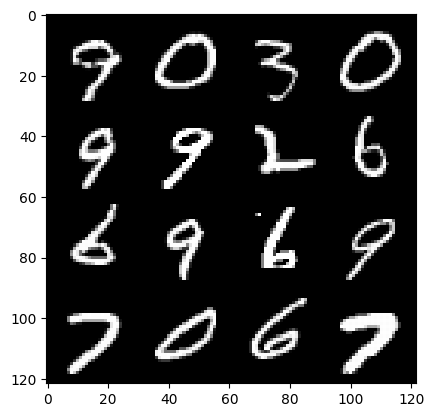

Epoch = 365 cur_step = 185255 disc_loss = 0.3253090106030263 gen_loss = 1.783032864751592


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

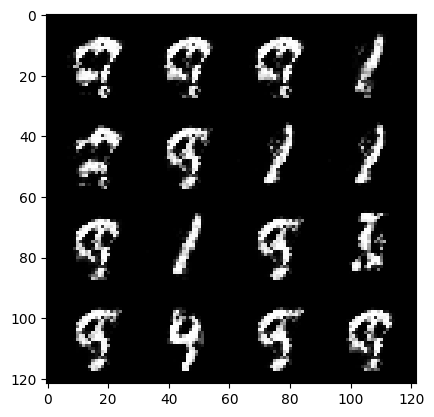

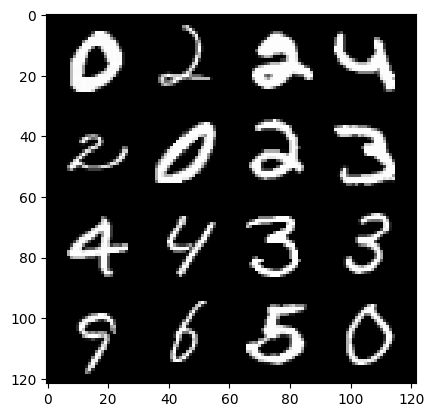

Epoch = 370 cur_step = 187600 disc_loss = 0.3646248543440406 gen_loss = 1.6500310188671674


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

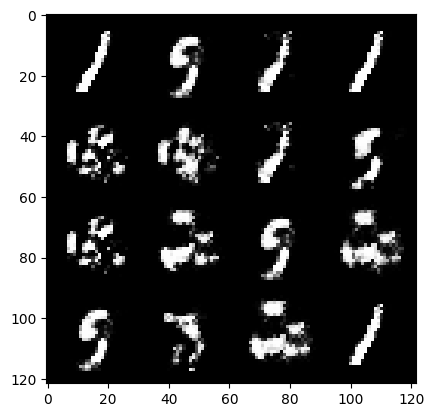

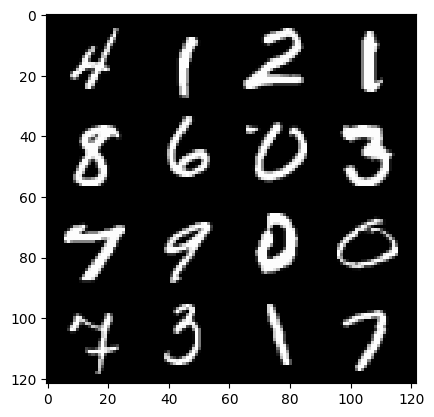

Epoch = 375 cur_step = 189945 disc_loss = 0.3583543320581603 gen_loss = 1.7003494030376995


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
for epoch in range(epochs):
    for real_img, labels in tqdm(dataloader):
        
        cur_bs = len(real_img)
        real_img = real_img.view(cur_bs, -1)
        
        ### Discrimnator
        disc_opt.zero_grad()
        real_img = real_img.to(device)
        
        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real_img, z_dim)
        
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        ### Generator
        gen_opt.zero_grad()
        
        gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
        
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        
        ### visualisation & stats
        mean_disc_loss += disc_loss.item()
        mean_gen_loss += gen_loss.item()
        
        if cur_step % info_step == 0 and cur_step > 0:
            fake_noise = gen_noise( cur_bs, z_dim)
            fake = gen(fake_noise)
            show(fake)
            show(real_img)
            print("Epoch =",epoch,"cur_step =",cur_step, "disc_loss =",mean_disc_loss/info_step, "gen_loss =",mean_gen_loss/info_step  )
            mean_gen_loss = 0
            mean_disc_loss = 0
        
        cur_step += 1

In [ ]:
def save_checkpoint(name):
    
    ## Gen model
    torch.save({
        'epoch' : epoch, 
        'model_state_dict' :gen.state_dict(),
        'optimizer_state_dict' : gen_opt.state_dict()
    }, save_path+'G-'+name+'.pkl')
    
    
    ## Critic Model
    torch.save({
        'epoch' : epoch, 
        'model_state_dict' :disc.state_dict(),
        'optimizer_state_dict' : disc_opt.state_dict()
    }, save_path+'D-'+name+'.pkl')
    
    print("Saved Checkpoint")


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/Num_generation/"
save_checkpoint(num_gen)